Loaded pretrained weights for efficientnet-b0
Using device: cuda

[Epoch 1/50]


Train Loss: 1.1301 | Train Acc: 0.6907 | Test Loss: 1.4589 | Test Acc: 0.5932
  [*] Best model updated.

[Epoch 2/50]


Train Loss: 0.6919 | Train Acc: 0.8983 | Test Loss: 1.0938 | Test Acc: 0.7571
  [*] Best model updated.

[Epoch 3/50]


Train Loss: 0.5606 | Train Acc: 0.9590 | Test Loss: 0.8848 | Test Acc: 0.8192
  [*] Best model updated.

[Epoch 4/50]


Train Loss: 0.5216 | Train Acc: 0.9760 | Test Loss: 0.7556 | Test Acc: 0.8757
  [*] Best model updated.

[Epoch 5/50]


Train Loss: 0.4940 | Train Acc: 0.9845 | Test Loss: 0.6625 | Test Acc: 0.9153
  [*] Best model updated.

[Epoch 6/50]


Train Loss: 0.4726 | Train Acc: 0.9915 | Test Loss: 0.7083 | Test Acc: 0.8927

[Epoch 7/50]


Train Loss: 0.4725 | Train Acc: 0.9887 | Test Loss: 0.6988 | Test Acc: 0.9040

[Epoch 8/50]


Train Loss: 0.5074 | Train Acc: 0.9718 | Test Loss: 0.8252 | Test Acc: 0.8531

[Epoch 9/50]


Train Loss: 0.4796 | Train Acc: 0.9915 | Test Loss: 0.7390 | Test Acc: 0.8983

[Epoch 10/50]


Train Loss: 0.4756 | Train Acc: 0.9915 | Test Loss: 0.7728 | Test Acc: 0.8531

[Epoch 11/50]


Train Loss: 0.4700 | Train Acc: 0.9915 | Test Loss: 0.7183 | Test Acc: 0.9040

[Epoch 12/50]


Train Loss: 0.4795 | Train Acc: 0.9859 | Test Loss: 0.8158 | Test Acc: 0.8701

[Epoch 13/50]


Train Loss: 0.4710 | Train Acc: 0.9915 | Test Loss: 0.7241 | Test Acc: 0.9040

[Epoch 14/50]


Train Loss: 0.4833 | Train Acc: 0.9831 | Test Loss: 0.8188 | Test Acc: 0.8644

[Epoch 15/50]


Train Loss: 0.5313 | Train Acc: 0.9633 | Test Loss: 0.8516 | Test Acc: 0.8079
Early Stopping Triggered!


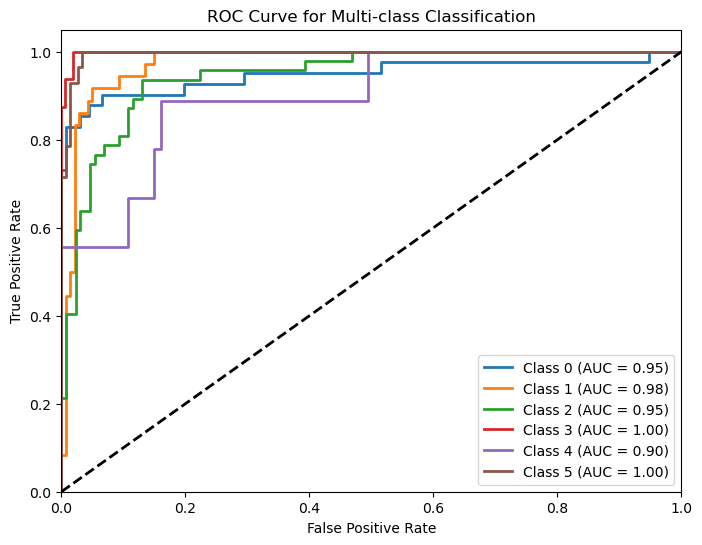

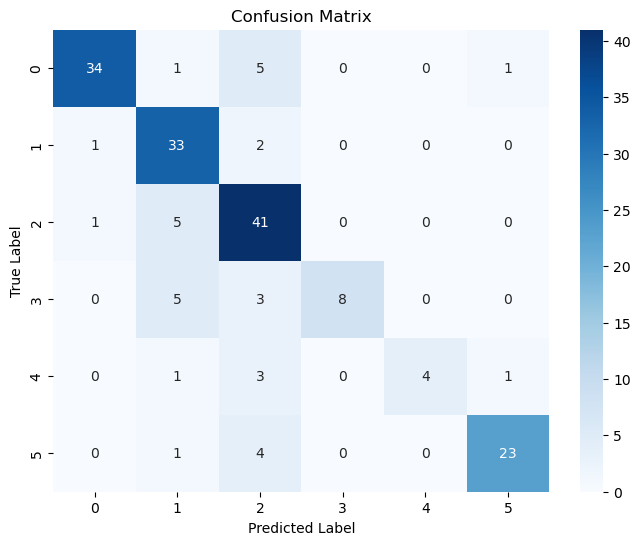


🔥 Best Accuracy: 0.9153


In [11]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize

# 시드 고정 및 결정론적 동작 설정
seed = 2021
deterministic = True
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

if deterministic:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Early Stopping 클래스
class EarlyStopping:
    def __init__(self, patience=10, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, test_loss):
        if self.best_loss is None or test_loss < self.best_loss - self.delta:
            self.best_loss = test_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# 하이퍼파라미터 설정
model_name = 'efficientnet-b0'
num_classes = 6
batch_size = 32
learning_rate = 0.001
image_size = EfficientNet.get_image_size(model_name)

# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 로드 (경로 수정 필요)
dataset_path = 'C:/Users/IIALAB/Desktop/kdm/solar/kaggle/input/solar-panel-images/Faulty_solar_panel'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# 데이터셋 분할 (80% 훈련, 20% 테스트)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoader 정의
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 모델 초기화 및 device 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EfficientNet.from_pretrained(model_name, num_classes=num_classes).to(device)
print("Using device:", device)

# 손실 함수 및 최적화 함수 정의
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# 학습 함수
def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

# 평가 함수
def evaluate(model, test_loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

best_acc = 0.0
num_epochs = 50
early_stopping = EarlyStopping(patience=10)

for epoch in range(num_epochs):
    print(f"\n[Epoch {epoch+1}/{num_epochs}]")
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    test_loss, test_acc = evaluate(model, test_loader, criterion)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

    if test_acc > best_acc:
        best_acc = test_acc
        model.load_state_dict(model.state_dict())  # 현재 모델의 가중치를 복사
        print("  [*] Best model updated.")

    early_stopping(test_loss)
    if early_stopping.early_stop:
        print("Early Stopping Triggered!")
        break

# AUC 커브 및 혼동 행렬 히트맵 시각화 함수
def plot_auc_and_confusion_matrix(model, test_loader, num_classes):
    model.eval()
    all_labels = []
    all_probs = []
    correct, total = 0, 0  # Accuracy 계산을 위한 변수

    # 테스트 데이터에 대해 예측 결과 및 확률 수집
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            # 데이터 저장
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

            # 정확도 계산
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # 다중 클래스 ROC를 위해 라벨 이진화
    labels_binarized = label_binarize(all_labels, classes=range(num_classes))

    # 클래스별 ROC 커브 및 AUC 계산
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # ROC 커브 시각화
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # 대각선 (랜덤 추측 기준)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-class Classification')
    plt.legend(loc="lower right")
    plt.show()

    # 예측된 라벨 생성 후 혼동 행렬 계산
    predicted_labels = np.argmax(all_probs, axis=1)
    cm = confusion_matrix(all_labels, predicted_labels)

    # 혼동 행렬 히트맵 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# 학습 종료 후 최고 성능 모델을 이용해 평가
plot_auc_and_confusion_matrix(model, test_loader, num_classes)
print(f"\n🔥 Best Accuracy: {best_acc:.4f}")


## EfficientNet + class

Loaded pretrained weights for efficientnet-b0
Using device: cuda

[Epoch 1/50]


Train Loss: 1.2062 | Train Acc: 0.6215 | Test Loss: 1.5193 | Test Acc: 0.4463
  [*] Best model updated.

[Epoch 2/50]


Train Loss: 0.7022 | Train Acc: 0.8941 | Test Loss: 1.3109 | Test Acc: 0.6497
  [*] Best model updated.

[Epoch 3/50]


Train Loss: 0.6180 | Train Acc: 0.9421 | Test Loss: 1.0197 | Test Acc: 0.7910
  [*] Best model updated.

[Epoch 4/50]


Train Loss: 0.5834 | Train Acc: 0.9647 | Test Loss: 0.9354 | Test Acc: 0.8023
  [*] Best model updated.

[Epoch 5/50]


Train Loss: 0.5644 | Train Acc: 0.9647 | Test Loss: 0.7322 | Test Acc: 0.8927
  [*] Best model updated.

[Epoch 6/50]


Train Loss: 0.5309 | Train Acc: 0.9760 | Test Loss: 0.7748 | Test Acc: 0.8757

[Epoch 7/50]


Train Loss: 0.5036 | Train Acc: 0.9845 | Test Loss: 0.7318 | Test Acc: 0.8870

[Epoch 8/50]


Train Loss: 0.5301 | Train Acc: 0.9788 | Test Loss: 0.7972 | Test Acc: 0.8588

[Epoch 9/50]


Train Loss: 0.5638 | Train Acc: 0.9633 | Test Loss: 0.8033 | Test Acc: 0.8588

[Epoch 10/50]


Train Loss: 0.5321 | Train Acc: 0.9746 | Test Loss: 0.8280 | Test Acc: 0.8644

[Epoch 11/50]


Train Loss: 0.5332 | Train Acc: 0.9718 | Test Loss: 0.8581 | Test Acc: 0.8870

[Epoch 12/50]


Train Loss: 0.5062 | Train Acc: 0.9802 | Test Loss: 0.7791 | Test Acc: 0.8814

[Epoch 13/50]


Train Loss: 0.4996 | Train Acc: 0.9802 | Test Loss: 0.7457 | Test Acc: 0.8814

[Epoch 14/50]


Train Loss: 0.4847 | Train Acc: 0.9873 | Test Loss: 0.7055 | Test Acc: 0.8814

[Epoch 15/50]


Train Loss: 0.4763 | Train Acc: 0.9944 | Test Loss: 0.7109 | Test Acc: 0.8814

[Epoch 16/50]


Train Loss: 0.5043 | Train Acc: 0.9831 | Test Loss: 0.7093 | Test Acc: 0.9096
  [*] Best model updated.

[Epoch 17/50]


Train Loss: 0.5011 | Train Acc: 0.9802 | Test Loss: 0.7459 | Test Acc: 0.8870

[Epoch 18/50]


Train Loss: 0.5052 | Train Acc: 0.9816 | Test Loss: 0.7296 | Test Acc: 0.8757

[Epoch 19/50]


Train Loss: 0.4778 | Train Acc: 0.9887 | Test Loss: 0.7385 | Test Acc: 0.8588

[Epoch 20/50]


Train Loss: 0.4827 | Train Acc: 0.9873 | Test Loss: 0.7478 | Test Acc: 0.8644

[Epoch 21/50]


Train Loss: 0.4949 | Train Acc: 0.9859 | Test Loss: 0.7673 | Test Acc: 0.8757

[Epoch 22/50]


Train Loss: 0.4972 | Train Acc: 0.9845 | Test Loss: 0.7493 | Test Acc: 0.8701

[Epoch 23/50]


Train Loss: 0.4963 | Train Acc: 0.9873 | Test Loss: 0.7604 | Test Acc: 0.8701

[Epoch 24/50]


Train Loss: 0.5677 | Train Acc: 0.9477 | Test Loss: 0.8541 | Test Acc: 0.8475
Early Stopping Triggered!


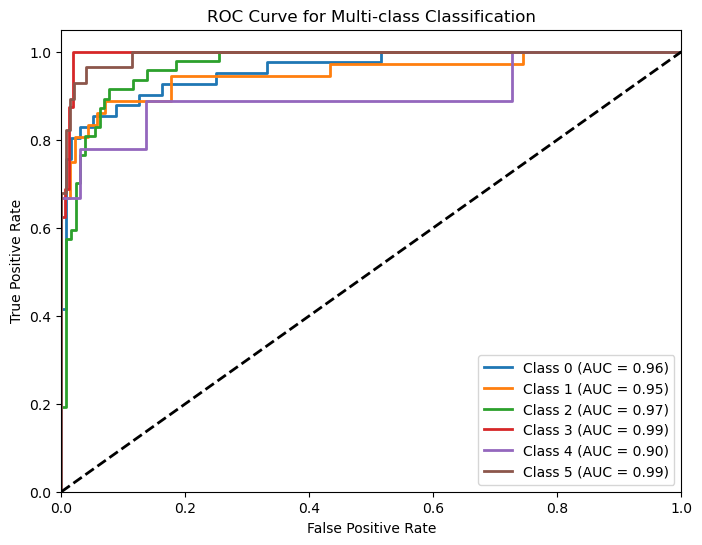

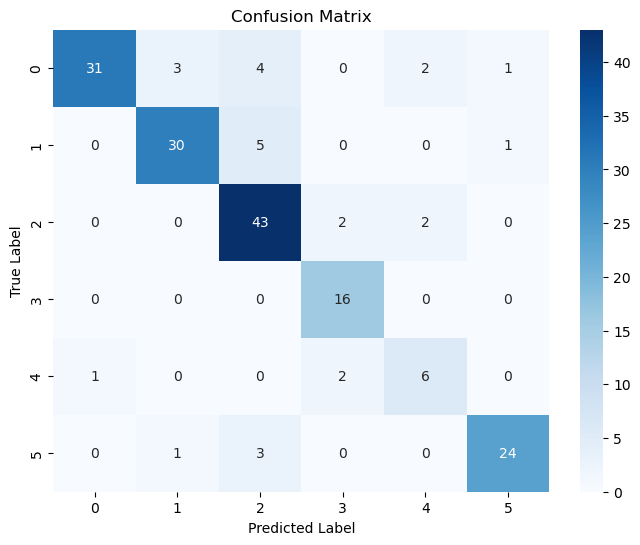


🔥 Best Accuracy: 0.9096


In [12]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize

# 시드 고정 및 결정론적 동작 설정
seed = 2021
deterministic = True
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

if deterministic:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Early Stopping 클래스
class EarlyStopping:
    def __init__(self, patience=10, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, test_loss):
        if self.best_loss is None or test_loss < self.best_loss - self.delta:
            self.best_loss = test_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# 하이퍼파라미터 설정
model_name = 'efficientnet-b0'
num_classes = 6
batch_size = 32
learning_rate = 0.001
image_size = EfficientNet.get_image_size(model_name)

# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 로드 (경로 수정 필요)
dataset_path = 'C:/Users/IIALAB/Desktop/kdm/solar/kaggle/input/solar-panel-images/Faulty_solar_panel'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# 데이터셋 분할 (80% 훈련, 20% 테스트)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoader 정의
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 모델 초기화 및 device 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EfficientNet.from_pretrained(model_name, num_classes=num_classes).to(device)

# 기존 FC Layer의 입력 차원 확인
in_features = model._fc.in_features  # EfficientNet의 FC 입력 차원

# 새로운 classifier 정의
model._fc = nn.Sequential(
    nn.Linear(in_features, 512),   # 기존 in_features에서 512로 축소
    nn.BatchNorm1d(512),           # 배치 정규화 추가
    nn.ReLU(),                     # 활성화 함수
    nn.Dropout(0.5),               # 드롭아웃 추가
    nn.Linear(512, num_classes)     # 최종 출력 (num_classes)
)

# 모델을 GPU/CPU로 이동
model.to(device)

print("Using device:", device)

# 손실 함수 및 최적화 함수 정의
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# 학습 함수
def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

# 평가 함수
def evaluate(model, test_loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

best_acc = 0.0
num_epochs = 50
early_stopping = EarlyStopping(patience=10)

for epoch in range(num_epochs):
    print(f"\n[Epoch {epoch+1}/{num_epochs}]")
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    test_loss, test_acc = evaluate(model, test_loader, criterion)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

    if test_acc > best_acc:
        best_acc = test_acc
        model.load_state_dict(model.state_dict())  # 현재 모델의 가중치를 복사
        print("  [*] Best model updated.")

    early_stopping(test_loss)
    if early_stopping.early_stop:
        print("Early Stopping Triggered!")
        break

# AUC 커브 및 혼동 행렬 히트맵 시각화 함수
def plot_auc_and_confusion_matrix(model, test_loader, num_classes):
    model.eval()
    all_labels = []
    all_probs = []
    correct, total = 0, 0  # Accuracy 계산을 위한 변수

    # 테스트 데이터에 대해 예측 결과 및 확률 수집
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            # 데이터 저장
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

            # 정확도 계산
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # 다중 클래스 ROC를 위해 라벨 이진화
    labels_binarized = label_binarize(all_labels, classes=range(num_classes))

    # 클래스별 ROC 커브 및 AUC 계산
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # ROC 커브 시각화
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # 대각선 (랜덤 추측 기준)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-class Classification')
    plt.legend(loc="lower right")
    plt.show()

    # 예측된 라벨 생성 후 혼동 행렬 계산
    predicted_labels = np.argmax(all_probs, axis=1)
    cm = confusion_matrix(all_labels, predicted_labels)

    # 혼동 행렬 히트맵 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# 학습 종료 후 최고 성능 모델을 이용해 평가
plot_auc_and_confusion_matrix(model, test_loader, num_classes)
print(f"\n🔥 Best Accuracy: {best_acc:.4f}")


In [5]:
from torchvision import datasets, transforms

# ✅ 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 로드 (경로 수정 필요)
dataset_path = 'C:/Users/IIALAB/Desktop/kdm/solar/kaggle/input/solar-panel-images/Faulty_solar_panel'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
class_names=dataset.classes
print(class_names)

['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']


Using device: cuda

[Epoch 1/50]


Train Loss: 1.8374 | Train Acc: 0.2825 | Test Loss: 6.0821 | Test Acc: 0.2034
  [*] Best model saved.

[Epoch 2/50]


Train Loss: 1.7016 | Train Acc: 0.3432 | Test Loss: 1.8021 | Test Acc: 0.2655
  [*] Best model saved.

[Epoch 3/50]


Train Loss: 1.6368 | Train Acc: 0.3545 | Test Loss: 1.4539 | Test Acc: 0.4294
  [*] Best model saved.

[Epoch 4/50]


Train Loss: 1.6347 | Train Acc: 0.3658 | Test Loss: 1.4503 | Test Acc: 0.4237

[Epoch 5/50]


Train Loss: 1.5754 | Train Acc: 0.3616 | Test Loss: 1.4582 | Test Acc: 0.4633
  [*] Best model saved.

[Epoch 6/50]


Train Loss: 1.5461 | Train Acc: 0.3814 | Test Loss: 1.8945 | Test Acc: 0.3164

[Epoch 7/50]


Train Loss: 1.5378 | Train Acc: 0.3898 | Test Loss: 1.4251 | Test Acc: 0.4463

[Epoch 8/50]


Train Loss: 1.5109 | Train Acc: 0.4195 | Test Loss: 1.3958 | Test Acc: 0.5537
  [*] Best model saved.

[Epoch 9/50]


Train Loss: 1.4999 | Train Acc: 0.4138 | Test Loss: 1.4284 | Test Acc: 0.4011

[Epoch 10/50]


Train Loss: 1.4730 | Train Acc: 0.4209 | Test Loss: 1.3693 | Test Acc: 0.5028

[Epoch 11/50]


Train Loss: 1.4797 | Train Acc: 0.4124 | Test Loss: 1.6021 | Test Acc: 0.4350

[Epoch 12/50]


Train Loss: 1.4323 | Train Acc: 0.4788 | Test Loss: 1.7215 | Test Acc: 0.4237

[Epoch 13/50]


Train Loss: 1.3810 | Train Acc: 0.5028 | Test Loss: 1.5649 | Test Acc: 0.4407

[Epoch 14/50]


Train Loss: 1.5413 | Train Acc: 0.4251 | Test Loss: 1.5312 | Test Acc: 0.4859

[Epoch 15/50]


Train Loss: 1.4016 | Train Acc: 0.5155 | Test Loss: 1.4867 | Test Acc: 0.3672

[Epoch 16/50]


Train Loss: 1.3318 | Train Acc: 0.5367 | Test Loss: 1.3132 | Test Acc: 0.5311

[Epoch 17/50]


Train Loss: 1.3677 | Train Acc: 0.4887 | Test Loss: 1.3528 | Test Acc: 0.5480

[Epoch 18/50]


Train Loss: 1.3267 | Train Acc: 0.5226 | Test Loss: 1.5240 | Test Acc: 0.4237

[Epoch 19/50]


Train Loss: 1.3562 | Train Acc: 0.5325 | Test Loss: 1.3674 | Test Acc: 0.5367

[Epoch 20/50]


Train Loss: 1.2691 | Train Acc: 0.5946 | Test Loss: 1.3818 | Test Acc: 0.5085

[Epoch 21/50]


Train Loss: 1.2554 | Train Acc: 0.5862 | Test Loss: 1.3396 | Test Acc: 0.5593
  [*] Best model saved.

[Epoch 22/50]


Train Loss: 1.2172 | Train Acc: 0.6003 | Test Loss: 1.4131 | Test Acc: 0.5480

[Epoch 23/50]


Train Loss: 1.1373 | Train Acc: 0.6540 | Test Loss: 1.4479 | Test Acc: 0.5028

[Epoch 24/50]


Train Loss: 1.1347 | Train Acc: 0.6709 | Test Loss: 1.4054 | Test Acc: 0.5480

[Epoch 25/50]


Train Loss: 1.1002 | Train Acc: 0.6681 | Test Loss: 1.2355 | Test Acc: 0.6384
  [*] Best model saved.

[Epoch 26/50]


Train Loss: 1.0637 | Train Acc: 0.6963 | Test Loss: 1.4229 | Test Acc: 0.5311

[Epoch 27/50]


Train Loss: 1.0782 | Train Acc: 0.6992 | Test Loss: 1.2589 | Test Acc: 0.5876

[Epoch 28/50]


Train Loss: 1.0486 | Train Acc: 0.7090 | Test Loss: 1.3803 | Test Acc: 0.5989

[Epoch 29/50]


Train Loss: 0.9993 | Train Acc: 0.7429 | Test Loss: 1.3429 | Test Acc: 0.5537

[Epoch 30/50]


Train Loss: 1.0410 | Train Acc: 0.7034 | Test Loss: 1.3336 | Test Acc: 0.5763

[Epoch 31/50]


Train Loss: 1.0547 | Train Acc: 0.7006 | Test Loss: 1.2383 | Test Acc: 0.6271

[Epoch 32/50]


Train Loss: 0.9994 | Train Acc: 0.7373 | Test Loss: 1.3471 | Test Acc: 0.5537

[Epoch 33/50]


Train Loss: 0.9000 | Train Acc: 0.7966 | Test Loss: 1.2276 | Test Acc: 0.6610
  [*] Best model saved.

[Epoch 34/50]


Train Loss: 0.9036 | Train Acc: 0.7839 | Test Loss: 1.4064 | Test Acc: 0.5819

[Epoch 35/50]


Train Loss: 0.8598 | Train Acc: 0.7895 | Test Loss: 1.2875 | Test Acc: 0.6158

[Epoch 36/50]


Train Loss: 0.7938 | Train Acc: 0.8319 | Test Loss: 1.2444 | Test Acc: 0.6497

[Epoch 37/50]


Train Loss: 0.8313 | Train Acc: 0.8220 | Test Loss: 1.2796 | Test Acc: 0.6384

[Epoch 38/50]


Train Loss: 0.7900 | Train Acc: 0.8418 | Test Loss: 1.2806 | Test Acc: 0.6441

[Epoch 39/50]


Train Loss: 0.7325 | Train Acc: 0.8771 | Test Loss: 1.3259 | Test Acc: 0.6328

[Epoch 40/50]


Train Loss: 0.7473 | Train Acc: 0.8686 | Test Loss: 1.5171 | Test Acc: 0.5424

[Epoch 41/50]


Train Loss: 0.8477 | Train Acc: 0.8291 | Test Loss: 1.2684 | Test Acc: 0.6610

[Epoch 42/50]


Train Loss: 0.8474 | Train Acc: 0.8220 | Test Loss: 1.3693 | Test Acc: 0.5876

[Epoch 43/50]


Train Loss: 0.6968 | Train Acc: 0.8842 | Test Loss: 1.3331 | Test Acc: 0.6328
Early Stopping Triggered!


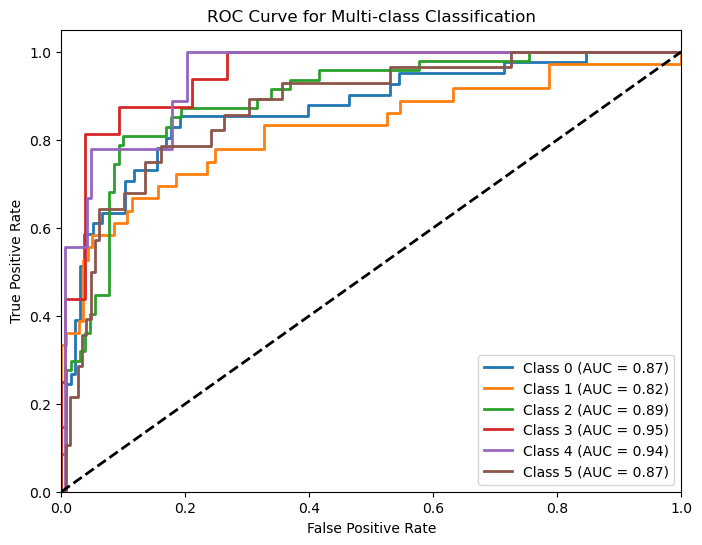

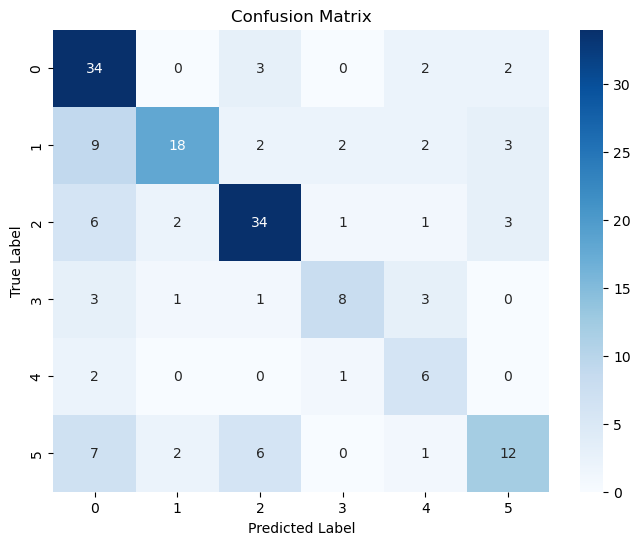


Best Accuracy: 0.6610


In [13]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

# ✅ 시드 고정
seed = 2021
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ✅ 하이퍼파라미터 설정
num_classes = 6
batch_size = 32
learning_rate = 0.001  # VGG19의 안정적인 학습을 위해 낮은 lr 사용
image_size = 224  # VGG19의 입력 크기

# ✅ 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ✅ 데이터셋 로드
dataset_path = 'C:/Users/IIALAB/Desktop/kdm/solar/kaggle/input/solar-panel-images/Faulty_solar_panel'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# ✅ 데이터셋 분할 (80% 훈련, 20% 테스트)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# ✅ DataLoader 정의
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ✅ VGG19 모델 불러오기 (EfficientNet과 유사한 방식 적용)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# ✅ 최신 PyTorch 권장 방식으로 사전 학습된 가중치 로드
model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)  # ✅ 최신 방식 사용
# ✅ 마지막 분류기 수정 (EfficientNet처럼 사용)
model.classifier[6] = nn.Sequential(
            nn.Linear(4096, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
model = model.to(device)


print("Using device:", device)

# ✅ 손실 함수 및 최적화 함수 정의 (EfficientNet과 동일한 방식 적용)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# ✅ Early Stopping 클래스
class EarlyStopping:
    def __init__(self, patience=10, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, test_loss):
        if self.best_loss is None or test_loss < self.best_loss - self.delta:
            self.best_loss = test_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# ✅ 학습 함수
def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

# ✅ 평가 함수
def evaluate(model, test_loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

# ✅ 학습 루프
epochs = 50
best_acc = 0.0
early_stopping = EarlyStopping(patience=10)

for epoch in range(epochs):
    print(f"\n[Epoch {epoch+1}/{epochs}]")
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    test_loss, test_acc = evaluate(model, test_loader, criterion)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

    if test_acc > best_acc:
        best_acc = test_acc
        model.load_state_dict(model.state_dict())  # 현재 모델의 가중치를 복사
        print("  [*] Best model saved.")

    early_stopping(test_loss)
    if early_stopping.early_stop:
        print("Early Stopping Triggered!")
        break

# AUC 커브 및 혼동 행렬 히트맵 시각화 함수
def plot_auc_and_confusion_matrix(model, test_loader, num_classes):
    model.eval()
    all_labels = []
    all_probs = []
    correct, total = 0, 0  # Accuracy 계산을 위한 변수

    # 테스트 데이터에 대해 예측 결과 및 확률 수집
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            # 데이터 저장
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

            # 정확도 계산
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # 다중 클래스 ROC를 위해 라벨 이진화
    labels_binarized = label_binarize(all_labels, classes=range(num_classes))

    # 클래스별 ROC 커브 및 AUC 계산
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # ROC 커브 시각화
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # 대각선 (랜덤 추측 기준)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-class Classification')
    plt.legend(loc="lower right")
    plt.show()

    # 예측된 라벨 생성 후 혼동 행렬 계산
    predicted_labels = np.argmax(all_probs, axis=1)
    cm = confusion_matrix(all_labels, predicted_labels)

    # 혼동 행렬 히트맵 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# 학습 종료 후 최고 성능 모델을 이용해 평가
plot_auc_and_confusion_matrix(model, test_loader, num_classes)

print(f"\nBest Accuracy: {best_acc:.4f}")


Loaded pretrained weights for efficientnet-b0

[Epoch 1/50]


Train Loss: 1.1377 | Train Acc: 0.6568 | Val Loss: 1.0561 | Val Acc: 0.6893
  [*] Best model saved.

[Epoch 2/50]


Train Loss: 0.6675 | Train Acc: 0.9181 | Val Loss: 1.1404 | Val Acc: 0.7514
  [*] Best model saved.

[Epoch 3/50]


Train Loss: 0.5639 | Train Acc: 0.9718 | Val Loss: 0.8426 | Val Acc: 0.8192
  [*] Best model saved.

[Epoch 4/50]


Train Loss: 0.5174 | Train Acc: 0.9901 | Val Loss: 0.7389 | Val Acc: 0.8927
  [*] Best model saved.

[Epoch 5/50]


Train Loss: 0.5156 | Train Acc: 0.9944 | Val Loss: 0.7442 | Val Acc: 0.8814

[Epoch 6/50]


Train Loss: 0.5069 | Train Acc: 0.9901 | Val Loss: 0.7154 | Val Acc: 0.8927

[Epoch 7/50]


Train Loss: 0.5136 | Train Acc: 0.9845 | Val Loss: 0.7722 | Val Acc: 0.8644

[Epoch 8/50]


Train Loss: 0.5188 | Train Acc: 0.9873 | Val Loss: 0.8273 | Val Acc: 0.8362

[Epoch 9/50]


Train Loss: 0.5278 | Train Acc: 0.9831 | Val Loss: 0.8061 | Val Acc: 0.8531

[Epoch 10/50]


Train Loss: 0.5271 | Train Acc: 0.9831 | Val Loss: 0.7853 | Val Acc: 0.8588

[Epoch 11/50]


Train Loss: 0.5619 | Train Acc: 0.9703 | Val Loss: 0.7450 | Val Acc: 0.8927

[Epoch 12/50]


Train Loss: 0.5311 | Train Acc: 0.9831 | Val Loss: 0.7890 | Val Acc: 0.8418

[Epoch 13/50]


Train Loss: 0.5212 | Train Acc: 0.9831 | Val Loss: 0.7529 | Val Acc: 0.8927

[Epoch 14/50]


Train Loss: 0.5353 | Train Acc: 0.9845 | Val Loss: 0.7710 | Val Acc: 0.8588

[Epoch 15/50]


Train Loss: 0.5426 | Train Acc: 0.9760 | Val Loss: 0.7693 | Val Acc: 0.8531

[Epoch 16/50]


Train Loss: 0.5271 | Train Acc: 0.9816 | Val Loss: 0.7400 | Val Acc: 0.8701
Early Stopping Triggered!


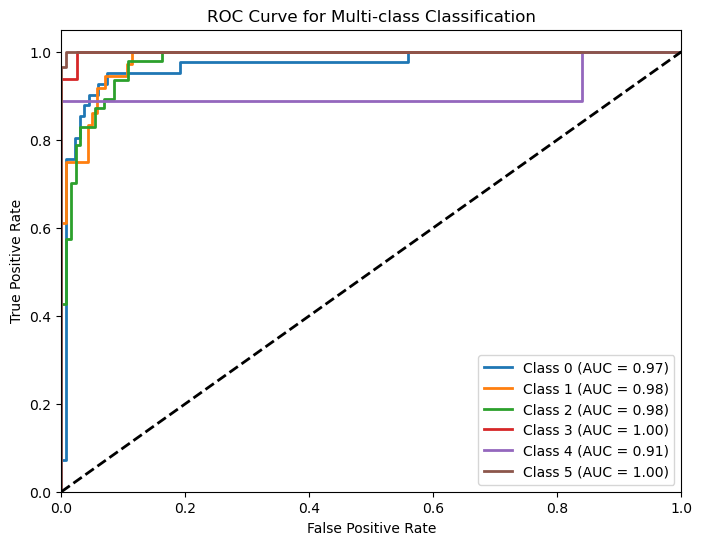

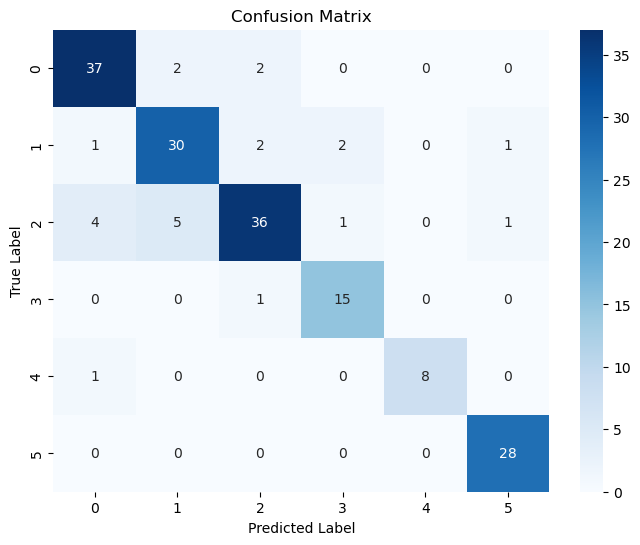


Best Accuracy: 0.8927


In [14]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm

# ✅ SEED 설정 (재현성 확보)
seed = 2021
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ✅ EarlyStopping
class EarlyStopping:
    def __init__(self, patience=10, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# ✅ Hybrid Model (EfficientNet + VGG19)
class HybridModel(nn.Module):
    def __init__(self, num_classes=6):
        super(HybridModel, self).__init__()
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b0')
        self.efficientnet._fc = nn.Identity()
        
        # ✅ VGG19 사용
        self.vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)
        self.vgg.classifier = nn.Identity()

        # Freeze EfficientNet의 초기 블록: Freeze blocks 0~2, Unfreeze 나머지
        for name, param in self.efficientnet.named_parameters():
            if "blocks.0" in name or "blocks.1" in name or "blocks.2" in name:
                param.requires_grad = False
            else:
                param.requires_grad = True

        # VGG 일부 Freeze (초반부)
        for name, param in self.vgg.named_parameters():
            if "features.0" in name or "features.1" in name or "features.2" in name or "features.3" in name or "features.4" in name or "features.5" in name:
                param.requires_grad = False
            else:
                param.requires_grad = True

        efficientnet_out_features = self.efficientnet._conv_head.out_channels  # 1280
        vgg_out_features = 512  # VGG19 출력 채널

        self.efficientnet_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.vgg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Linear(efficientnet_out_features + vgg_out_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        eff_features = self.efficientnet.extract_features(x)
        eff_features = self.efficientnet_pool(eff_features)
        eff_features = eff_features.view(eff_features.size(0), -1)

        vgg_features = self.vgg.features(x)
        vgg_features = self.vgg_pool(vgg_features)
        vgg_features = vgg_features.view(vgg_features.size(0), -1)

        fused_features = torch.cat([eff_features, vgg_features], dim=1)
        return self.classifier(fused_features)

# ==============================
# ✅ 데이터 로딩
# ==============================
image_size = 224
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset_path = "C:/Users/IIALAB/Desktop/kdm/solar/kaggle/input/solar-panel-images/Faulty_solar_panel"

dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ==============================
# ✅ 모델, 손실 함수, 최적화기 설정
# ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridModel(num_classes=6).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# ✅ Early Stopping 적용
early_stopping = EarlyStopping(patience=10)

# ✅ 학습 함수
def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

# ✅ 평가 함수
def evaluate(model, val_loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

# ✅ 학습 루프
best_acc = 0.0
num_epochs = 50

for epoch in range(num_epochs):
    print(f"\n[Epoch {epoch+1}/{num_epochs}]")
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, test_loader, criterion)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        model.load_state_dict(model.state_dict())  # 현재 모델의 가중치를 복사
        print("  [*] Best model saved.")

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early Stopping Triggered!")
        break

# AUC 커브 및 혼동 행렬 히트맵 시각화 함수
def plot_auc_and_confusion_matrix(model, test_loader, num_classes):
    model.eval()
    all_labels = []
    all_probs = []
    correct, total = 0, 0  # Accuracy 계산을 위한 변수

    # 테스트 데이터에 대해 예측 결과 및 확률 수집
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            # 데이터 저장
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

            # 정확도 계산
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # 다중 클래스 ROC를 위해 라벨 이진화
    labels_binarized = label_binarize(all_labels, classes=range(num_classes))

    # 클래스별 ROC 커브 및 AUC 계산
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # ROC 커브 시각화
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # 대각선 (랜덤 추측 기준)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-class Classification')
    plt.legend(loc="lower right")
    plt.show()

    # 예측된 라벨 생성 후 혼동 행렬 계산
    predicted_labels = np.argmax(all_probs, axis=1)
    cm = confusion_matrix(all_labels, predicted_labels)

    # 혼동 행렬 히트맵 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# 학습 종료 후 최고 성능 모델을 이용해 평가
plot_auc_and_confusion_matrix(model, test_loader, num_classes)
print(f"\nBest Accuracy: {best_acc:.4f}")


Loaded pretrained weights for efficientnet-b0

[Epoch 1/50]


Train Loss: 1.3824 | Train Acc: 0.5480 | Val Loss: 2.3458 | Val Acc: 0.5254
  [*] Best model saved.

[Epoch 2/50]


Train Loss: 0.8542 | Train Acc: 0.8150 | Val Loss: 0.8132 | Val Acc: 0.8531
  [*] Best model saved.

[Epoch 3/50]


Train Loss: 0.6719 | Train Acc: 0.8983 | Val Loss: 0.9239 | Val Acc: 0.8023

[Epoch 4/50]


Train Loss: 0.6610 | Train Acc: 0.9153 | Val Loss: 1.1160 | Val Acc: 0.7175

[Epoch 5/50]


Train Loss: 0.6001 | Train Acc: 0.9421 | Val Loss: 0.7280 | Val Acc: 0.8870
  [*] Best model saved.

[Epoch 6/50]


Train Loss: 0.5524 | Train Acc: 0.9605 | Val Loss: 0.7456 | Val Acc: 0.8870

[Epoch 7/50]


Train Loss: 0.5722 | Train Acc: 0.9548 | Val Loss: 0.7690 | Val Acc: 0.8475

[Epoch 8/50]


Train Loss: 0.5978 | Train Acc: 0.9477 | Val Loss: 0.7629 | Val Acc: 0.8757

[Epoch 9/50]


Train Loss: 0.5714 | Train Acc: 0.9562 | Val Loss: 0.8689 | Val Acc: 0.8192

[Epoch 10/50]


Train Loss: 0.5928 | Train Acc: 0.9506 | Val Loss: 0.7792 | Val Acc: 0.8644

[Epoch 11/50]


Train Loss: 0.6323 | Train Acc: 0.9364 | Val Loss: 0.7337 | Val Acc: 0.8814

[Epoch 12/50]


Train Loss: 0.5486 | Train Acc: 0.9703 | Val Loss: 0.7049 | Val Acc: 0.8870

[Epoch 13/50]


Train Loss: 0.5262 | Train Acc: 0.9746 | Val Loss: 0.7097 | Val Acc: 0.8870

[Epoch 14/50]


Train Loss: 0.5042 | Train Acc: 0.9816 | Val Loss: 0.6856 | Val Acc: 0.9040
  [*] Best model saved.

[Epoch 15/50]


Train Loss: 0.4984 | Train Acc: 0.9887 | Val Loss: 0.6758 | Val Acc: 0.9379
  [*] Best model saved.

[Epoch 16/50]


Train Loss: 0.5300 | Train Acc: 0.9788 | Val Loss: 0.7381 | Val Acc: 0.8983

[Epoch 17/50]


Train Loss: 0.5568 | Train Acc: 0.9619 | Val Loss: 0.8909 | Val Acc: 0.8305

[Epoch 18/50]


Train Loss: 0.5141 | Train Acc: 0.9845 | Val Loss: 0.7732 | Val Acc: 0.8531

[Epoch 19/50]


Train Loss: 0.5013 | Train Acc: 0.9887 | Val Loss: 0.7262 | Val Acc: 0.8870

[Epoch 20/50]


Train Loss: 0.5033 | Train Acc: 0.9929 | Val Loss: 0.8031 | Val Acc: 0.8418

[Epoch 21/50]


Train Loss: 0.5348 | Train Acc: 0.9718 | Val Loss: 0.8219 | Val Acc: 0.8305

[Epoch 22/50]


Train Loss: 0.5211 | Train Acc: 0.9788 | Val Loss: 0.8292 | Val Acc: 0.8418

[Epoch 23/50]


Train Loss: 0.5081 | Train Acc: 0.9859 | Val Loss: 0.7622 | Val Acc: 0.8475

[Epoch 24/50]


Train Loss: 0.5196 | Train Acc: 0.9816 | Val Loss: 0.8022 | Val Acc: 0.8588

[Epoch 25/50]


Train Loss: 0.4883 | Train Acc: 0.9915 | Val Loss: 0.7800 | Val Acc: 0.8531
Early Stopping Triggered!


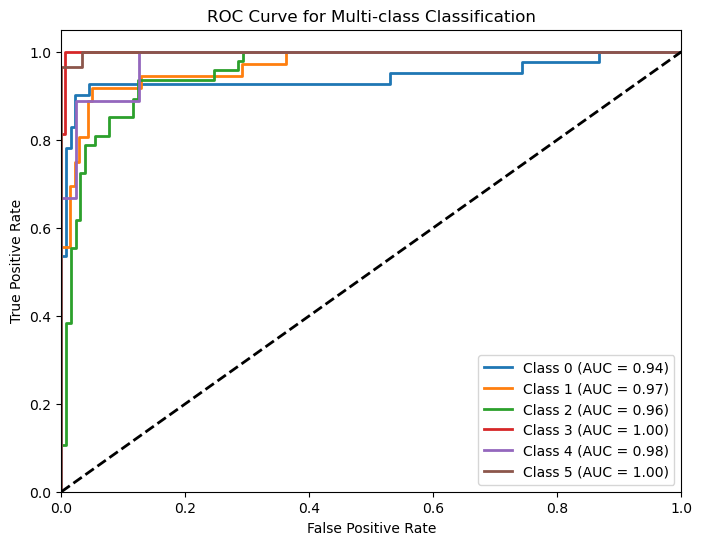

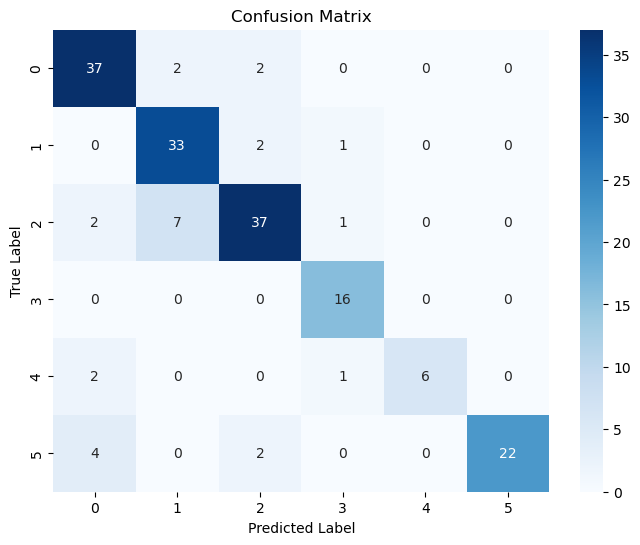


Best Accuracy: 0.9379


In [6]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm

# ✅ SEED 설정 (재현성 확보)
seed = 2021
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ✅ EarlyStopping
class EarlyStopping:
    def __init__(self, patience=10, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# ✅ Residual Block 정의
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels or stride != 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        x = nn.ReLU()(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        return nn.ReLU()(x)

# ✅ ASPP Block 정의
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels=256):
        super(ASPP, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.conv3_1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, dilation=1)
        self.conv3_6 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=6, dilation=6)
        self.conv3_12 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=12, dilation=12)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.conv1_for_global = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.conv1x1_out = nn.Conv2d(out_channels * 5, out_channels, kernel_size=1)

    def forward(self, x):
        conv1_out = self.conv1(x)
        conv3_1_out = self.conv3_1(x)
        conv3_6_out = self.conv3_6(x)
        conv3_12_out = self.conv3_12(x)

        global_avg = self.global_avg_pool(x)
        global_avg = self.conv1_for_global(global_avg)
        global_avg = nn.functional.interpolate(global_avg, size=conv1_out.shape[2:], mode='bilinear', align_corners=True)

        out = torch.cat([conv1_out, conv3_1_out, conv3_6_out, conv3_12_out, global_avg], dim=1)
        return self.conv1x1_out(out)

# ✅ Hybrid Model (EfficientNet + VGG19 + Residual + ASPP)
class HybridModel(nn.Module):
    def __init__(self, num_classes=6):
        super(HybridModel, self).__init__()
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b0')
        self.efficientnet._fc = nn.Identity()
        # ✅ VGG19 사용
        self.vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)
        self.vgg.classifier = nn.Identity()

        # Freeze EfficientNet의 초기 블록: Freeze blocks 0~2, Unfreeze 나머지
        for name, param in self.efficientnet.named_parameters():
            if "blocks.0" in name or "blocks.1" in name or "blocks.2" in name:
                param.requires_grad = False
            else:
                param.requires_grad = True

        # VGG 일부 Freeze (초반부)
        for name, param in self.vgg.named_parameters():
            if "features.0" in name or "features.1" in name or "features.2" in name or "features.3" in name or "features.4" in name or "features.5" in name:
                param.requires_grad = False
            else:
                param.requires_grad = True

        efficientnet_out_features = self.efficientnet._conv_head.out_channels  # 1280
        vgg_out_features = 512  # VGG19 출력 채널

        self.efficientnet_pool = nn.AdaptiveAvgPool2d((7, 7))
        self.vgg_pool = nn.AdaptiveAvgPool2d((7, 7))

        self.eff_conv1x1 = nn.Conv2d(efficientnet_out_features, 1024, kernel_size=1)
        self.vgg_conv1x1 = nn.Conv2d(vgg_out_features, 1024, kernel_size=1)

        self.res_block = ResidualBlock(2048, 2048)
        self.aspp = ASPP(in_channels=2048, out_channels=256)

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        eff_features = self.efficientnet.extract_features(x)
        eff_features = self.efficientnet_pool(eff_features)
        eff_features = self.eff_conv1x1(eff_features)

        vgg_features = self.vgg.features(x)
        vgg_features = self.vgg_pool(vgg_features)
        vgg_features = self.vgg_conv1x1(vgg_features)

        fused_features = torch.cat([eff_features, vgg_features], dim=1)  # (batch, 2048, 7, 7)
        fused_features = self.res_block(fused_features)
        aspp_features = self.aspp(fused_features)
        gap_features = self.global_avg_pool(aspp_features)
        flattened_features = gap_features.view(gap_features.size(0), -1)
        return self.classifier(flattened_features)



# ==============================
# ✅ 데이터 로딩
# ==============================
image_size = 224
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset_path = "C:/Users/IIALAB/Desktop/kdm/solar/kaggle/input/solar-panel-images/Faulty_solar_panel"

dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ==============================
# ✅ 모델, 손실 함수, 최적화기 설정
# ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridModel(num_classes=6).to(device)  # 모델을 먼저 생성해야 함!

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# ✅ Early Stopping 적용
early_stopping = EarlyStopping(patience=10)

# ✅ 학습 함수
def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

# ✅ 평가 함수
def evaluate(model, val_loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

# ✅ 학습 루프
best_acc = 0.0
num_epochs = 50

for epoch in range(num_epochs):
    print(f"\n[Epoch {epoch+1}/{num_epochs}]")
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, test_loader, criterion)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        model.load_state_dict(model.state_dict())  # 현재 모델의 가중치를 복사
        print("  [*] Best model saved.")

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early Stopping Triggered!")
        break

# AUC 커브 및 혼동 행렬 히트맵 시각화 함수
def plot_auc_and_confusion_matrix(model, test_loader, num_classes):
    model.eval()
    all_labels = []
    all_probs = []
    correct, total = 0, 0  # Accuracy 계산을 위한 변수

    # 테스트 데이터에 대해 예측 결과 및 확률 수집
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            # 데이터 저장
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

            # 정확도 계산
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # 다중 클래스 ROC를 위해 라벨 이진화
    labels_binarized = label_binarize(all_labels, classes=range(num_classes))

    # 클래스별 ROC 커브 및 AUC 계산
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # ROC 커브 시각화
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # 대각선 (랜덤 추측 기준)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-class Classification')
    plt.legend(loc="lower right")
    plt.show()

    # 예측된 라벨 생성 후 혼동 행렬 계산
    predicted_labels = np.argmax(all_probs, axis=1)
    cm = confusion_matrix(all_labels, predicted_labels)

    # 혼동 행렬 히트맵 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# 학습 종료 후 최고 성능 모델을 이용해 평가
plot_auc_and_confusion_matrix(model, test_loader, num_classes)
print(f"\nBest Accuracy: {best_acc:.4f}")

